In [1]:
%matplotlib inline
import sys
sys.path.insert(0, '/astro/users/ctslater/.local/lib/python3.6/site-packages')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.coordinates
import astropy.units as u

#plt.style.use(("paper_plots.mplstyle"))

matplotlib.rcParams['figure.dpi'] = 80

from astropy.coordinates import Galactocentric, Galactic, ICRS

import healpy as hp

cmap = matplotlib.cm.coolwarm.set_under('w')


In [40]:
#ra, dec = hp.pix2ang(hp.order2nside(7), np.arange(hp.nside2npix(hp.order2nside(7))),
#                                    lonlat=True, nest=True)
ra, dec = 20, 30

ncoords = 1000

equatorial_coords = astropy.coordinates.SkyCoord(ra*u.deg, dec*u.deg, 10*u.kpc, frame='icrs')
coords = equatorial_coords #equatorial_coords.galactic

velocities = np.random.multivariate_normal([0, 0, 0], np.diag([80, 80, 80]), ncoords)

gc_coord = Galactocentric(x=coords.galactocentric.x + np.zeros(velocities.shape[0]),
                          y=coords.galactocentric.y + np.zeros(velocities.shape[0]),
                          z=coords.galactocentric.z + np.zeros(velocities.shape[0]),
                          v_x = velocities[:,0] * u.km/u.s,
                          v_y = velocities[:,1] * u.km/u.s,
                          v_z = velocities[:,2] * u.km/u.s,
                          # galcen_v_sun=coord.CartesianDifferential([0,220,0]*u.km/u.s)
                          )
#print(gc_coord[0])
galactic_coords_w_pm = gc_coord.transform_to(Galactic)

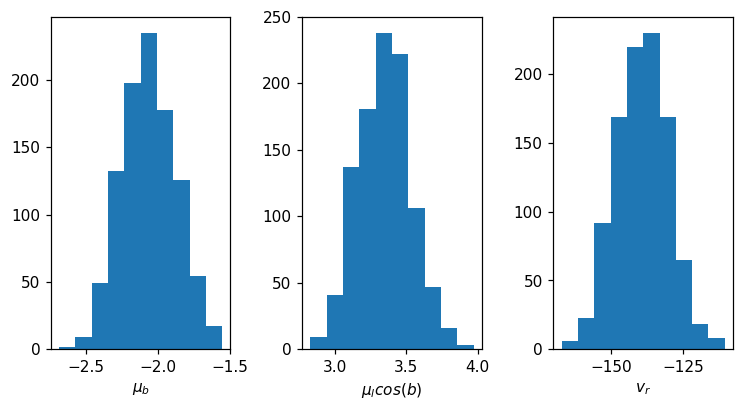

In [41]:
plt.figure(dpi=110, figsize=(8,4))

#def plot_common():
    
plt.subplot(1, 3, 1)
plt.hist(galactic_coords_w_pm.pm_b.to_value())
plt.xlabel(r"$\mu_b$")

plt.subplot(1, 3, 2)
plt.hist(galactic_coords_w_pm.pm_l_cosb.to_value())
plt.xlabel(r"$\mu_l cos(b)$")

plt.subplot(1, 3, 3)
plt.hist(galactic_coords_w_pm.radial_velocity.to_value())
plt.xlabel(r"$v_r$")

plt.subplots_adjust(wspace=0.4)

Text(0,0.5,'$\\mu_l cos(b)$')

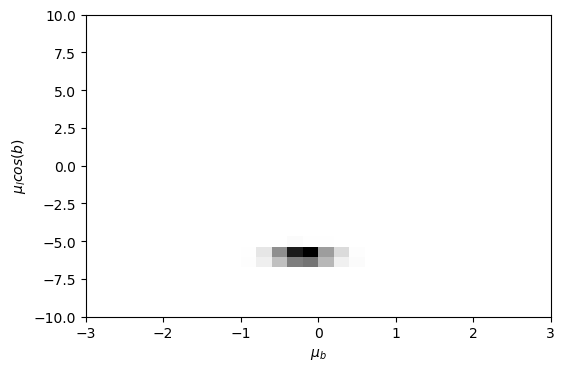

In [4]:

plt.figure(dpi=100)

ranges = ((-3, 3), (-10, 10))
extent = sum(ranges, ())
H, _, _ = np.histogram2d(galactic_coords_w_pm.pm_b.to_value(),
                         galactic_coords_w_pm.pm_l_cosb.to_value(),
                         bins=(30, 30),
                         range=ranges)

plt.imshow(H.T, cmap='gray_r', origin='lower', extent=extent, aspect='auto')
plt.xlabel(r"$\mu_b$")
plt.ylabel(r"$\mu_l cos(b)$")


In [44]:
def make_xyz_to_pm_matrix(coord):

    raw_rows = []
    for vx, vy, vz in [(1,0,0), (0,1,0), (0,0,1), (0, 0, 0)]:
        gc_coord = Galactocentric(x=coord.galactocentric.x,
                                  y=coord.galactocentric.y,
                                  z=coord.galactocentric.z,
                                  v_x = vx * u.km/u.s,
                                  v_y = vy * u.km/u.s,
                                  v_z = vz * u.km/u.s,
                                  # galcen_v_sun=coord.CartesianDifferential([0,220,0]*u.km/u.s)
                                  )
        
        galactic_coords_w_pm = gc_coord.transform_to(Galactic)
        raw_rows.append(np.array([galactic_coords_w_pm.pm_b.to_value(),
                                  galactic_coords_w_pm.pm_l_cosb.to_value(),
                                  galactic_coords_w_pm.radial_velocity.to_value()]))


    center = raw_rows[-1]
    matrix_rows = [row - center for row in raw_rows[:-1]]
    return np.matrix(matrix_rows), center


In [45]:
#coord = astropy.coordinates.SkyCoord(180*u.deg, 0*u.deg, 10*u.kpc, frame='galactic')
ra, dec = 20, 30
coord = astropy.coordinates.SkyCoord(ra*u.deg, dec*u.deg, 10*u.kpc, frame='icrs')
m, center = make_xyz_to_pm_matrix(coord)
m

matrix([[-7.26024968e-03, -1.60973685e-02, -5.47027551e-01],
        [ 8.64080724e-03, -1.36333788e-02,  6.43839769e-01],
        [ 1.78219598e-02,  5.23221446e-05, -5.35005804e-01]])

In [48]:
n_samples = 300
velocities = np.random.multivariate_normal([0, 0, 0], np.diag([80, 80, 80]), n_samples)
converted_vels = np.matmul(np.matrix(velocities), m) + center

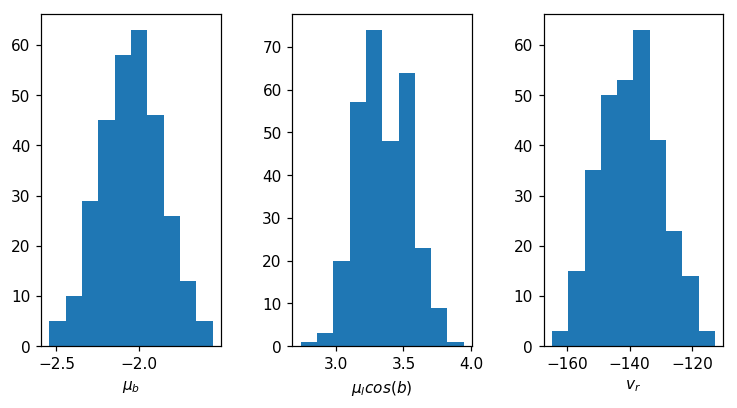

In [50]:
plt.figure(dpi=110, figsize=(8,4))

plt.subplot(1, 3, 1)
plt.hist(converted_vels[:,0])
plt.xlabel(r"$\mu_b$")

plt.subplot(1, 3, 2)
plt.hist(converted_vels[:,1])
plt.xlabel(r"$\mu_l cos(b)$")

plt.subplot(1, 3, 3)
plt.hist(converted_vels[:,2])
plt.xlabel(r"$v_r$")

plt.subplots_adjust(wspace=0.4)